In [45]:
import sys
sys.path.append('../../..')

In [46]:
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

from rnn import RNN
from CustomDL.loops.regression import train_loop, test_loop

torch.manual_seed(0)

# Setup

In [3]:
def run_epochs(
    epochs,
    model, loss_fn, optimizer,
    train_loader, test_loader,
    use_gpu: bool = False
) -> dict:
    loss = {
        'train': [],
        'eval': []
    }
    for epoch in range(1, epochs + 1):
        print(f"{epoch}/{epochs}")
        train_loss = train_loop(
            model, train_loader,
            loss_fn, optimizer, True,
            use_gpu=use_gpu
        )
        loss['train'].append(sum(train_loss) / len(train_loss))
        print(f"  Average Training Loss: {loss['train'][-1]:.6f}")

        eval_loss = test_loop(
            model, test_loader, loss_fn,
            use_gpu=use_gpu
        )
        loss['eval'].append(eval_loss)
        print(f"  Average Eval Loss: {loss['eval'][-1]:.6f}")
    
    return loss

# Synthesizing Sequential Data

In [47]:
sampling_rate = 10
total_secs = 500
delta = total_secs / (sampling_rate * total_secs)

t = torch.linspace(0, total_secs, sampling_rate * total_secs)
wave = lambda t: torch.cos(2 * torch.pi * t) / (.02 * t + 2) + 0.05 * torch.cos(4 * torch.pi * t)
data = (
    wave(t) + wave(t - delta) ** 2 - torch.cos(wave(t - 2 * delta)) * torch.tanh(wave(t - 2 * delta))
)

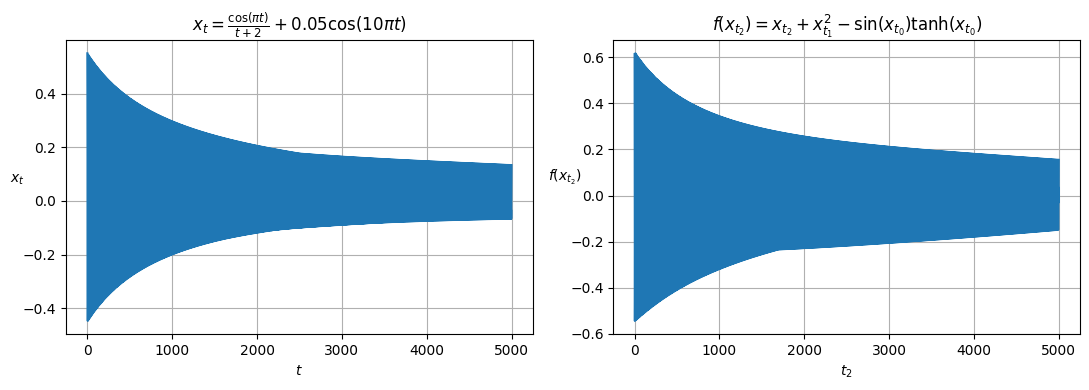

In [48]:
fig = plt.figure(figsize=(11, 4))
axes = fig.subplots(1, 2)


axes[0].set_title(r'$x_t = \frac{\cos(\pi t)}{t+2} + 0.05\cos(10\pi t)$')
axes[0].plot(wave(t))
axes[0].set_xlabel(r'$t$')
axes[0].set_ylabel(r'$x_t$', rotation=0)
axes[0].grid()


axes[1].set_title(r'$f(x_{t_2})=x_{t_2} + x_{t_1}^2 - \sin(x_{t_0})\tanh(x_{t_0})$')
axes[1].plot(data)
axes[1].set_xlabel(r'${t_2}$')
axes[1].set_ylabel(r'$f(x_{t_2})$', rotation=0)
axes[1].grid()

fig.tight_layout();

# Defining the dataset

In [8]:
class WaveDataset(Dataset):
    def __init__(self,
        wave: torch.Tensor,
        lag_duration: int
    ):
        super().__init__()
        self._wave = wave.unsqueeze(1)
        self._lag_dur = lag_duration
        self._total_seq = self._wave.shape[0] - self._lag_dur
    
    def __len__(self) -> int:
        return self._total_seq
    def __getitem__(self, index):
        if index < 0:
            raise IndexError("Only support non-negative index")
        elif index > len(self):
            raise IndexError(f"Index out of range for length {len(self)}")
        return (
            self._wave[index : index + self._lag_dur],
            self._wave[index + self._lag_dur]
        )

In [9]:
dataset = WaveDataset(data, 5)

train_idx = torch.arange(0, len(dataset) * .8, dtype=torch.int32)
test_idx = torch.arange(train_idx[-1] + 1, len(dataset))

train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

In [10]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size, True)
test_loader = DataLoader(test_set, batch_size, True)

# Predicting the curve

## Training

Let's build a simple MLP model to predict the sequential data. Because the model be given dimensions to initialize the weights and biases, we will let the lag duration be 5. That is, the model will be given ahead three observations to predict the next sample. 

In [17]:
mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(5, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
if torch.cuda.is_available():
    mlp_model.cuda()

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), 1e-5)

global_loss = {
    'train': [],
    'eval': []
}

In [33]:
loss = run_epochs(
    10, mlp_model, mse_loss,
    optimizer, train_loader, test_loader,
    torch.cuda.is_available()
)

global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

1/10


100%|██████████| 125/125 [00:00<00:00, 163.82it/s, loss=0.00013983606186229736]


  Average Training Loss: 0.000125
  Average Eval Loss: 0.000484
2/10


100%|██████████| 125/125 [00:00<00:00, 199.90it/s, loss=0.0001271662476938218] 


  Average Training Loss: 0.000122
  Average Eval Loss: 0.000465
3/10


100%|██████████| 125/125 [00:00<00:00, 172.63it/s, loss=4.6350196498679e-05]   


  Average Training Loss: 0.000119
  Average Eval Loss: 0.000467
4/10


100%|██████████| 125/125 [00:00<00:00, 174.95it/s, loss=7.384141645161435e-05] 


  Average Training Loss: 0.000117
  Average Eval Loss: 0.000453
5/10


100%|██████████| 125/125 [00:00<00:00, 187.27it/s, loss=9.222575317835435e-05] 


  Average Training Loss: 0.000114
  Average Eval Loss: 0.000444
6/10


100%|██████████| 125/125 [00:00<00:00, 155.55it/s, loss=0.00011168011405970901]


  Average Training Loss: 0.000112
  Average Eval Loss: 0.000438
7/10


100%|██████████| 125/125 [00:00<00:00, 181.43it/s, loss=0.00011298275785520673]


  Average Training Loss: 0.000109
  Average Eval Loss: 0.000438
8/10


100%|██████████| 125/125 [00:00<00:00, 197.97it/s, loss=0.00011406787962187082]


  Average Training Loss: 0.000107
  Average Eval Loss: 0.000425
9/10


100%|██████████| 125/125 [00:00<00:00, 177.11it/s, loss=0.00010424856009194627]


  Average Training Loss: 0.000104
  Average Eval Loss: 0.000408
10/10


100%|██████████| 125/125 [00:00<00:00, 169.11it/s, loss=6.618245970457792e-05] 


  Average Training Loss: 0.000102
  Average Eval Loss: 0.000402


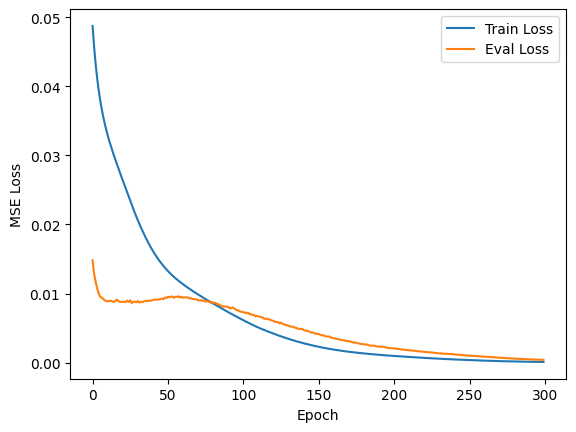

In [34]:
plt.plot(global_loss['train'], label='Train Loss')
plt.plot(global_loss['eval'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend();

In [35]:
checkpoint = {
    'model': mlp_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': global_loss
}

torch.save(checkpoint, '../output/mlp_wave.tar')

## Inference

In [ ]:
mlp_model.eval()
pred = []

with torch.no_grad():
    pred = torch.concat([
        mlp_model(X.cuda() if torch.cuda.is_available() else X).cpu()
        for X, _ in tqdm(DataLoader(dataset, batch_size, False))
    ]).squeeze()

100%|██████████| 157/157 [00:00<00:00, 264.43it/s]


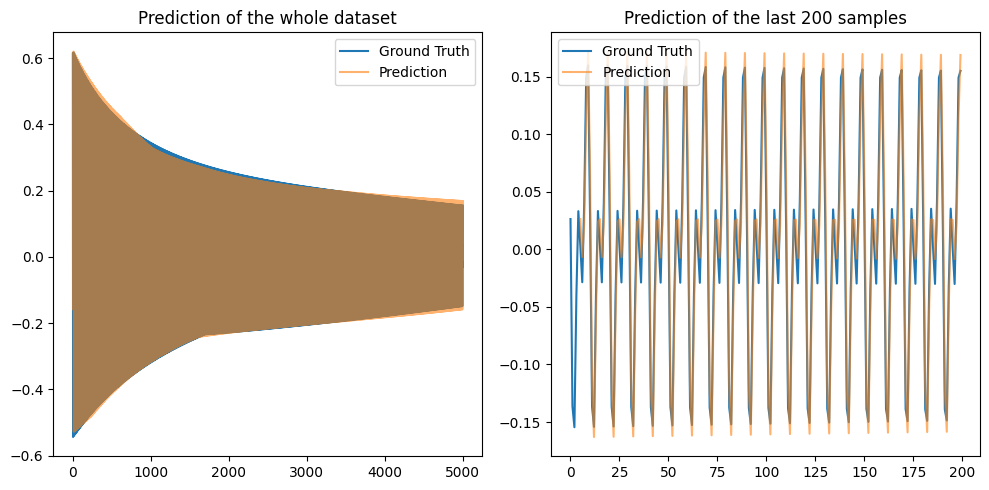

In [74]:
fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(1, 2)

axes[0].plot(data, label='Ground Truth')
axes[0].plot(list(range(5, data.shape[0])), pred, label="Prediction", alpha=.6)
axes[0].legend()
axes[0].set_title("Prediction of the whole dataset")


axes[1].plot(data[4800:], label='Ground Truth')
axes[1].plot(list(range(5, data[4800:].shape[0])), pred[4800:], label="Prediction", alpha=.6)
axes[1].legend()
axes[1].set_title("Prediction of the last 200 samples")

fig.tight_layout();

Our model performs great with the five observations we have given it with slightly small errors. This is relatively trivial as our function contains all information regarding the lag of 5. Of course, the other errors stem from the autocorrelation of higher lag.

However, what happens if say we only have the previous observation? What about fine-tuning our model on a different distribution that require more than 5 past observations to account for the other errors? All of this require our model to be flexible in terms of the input's dimension.

This is something that the RNN can solve.

# The Recurrent Network
The idea here is, instead of scaling the width of our hidden layers by the lag duration, we fix the hidden layer's dimension and use that layer for all past observations.

Here we will use the Elmann's recurrent network to do this. The Elmann's network specifies two sets of weights and biases. The first set of weights and biases is for encoding the input, let us call this `w_in_hidden`. The second set of weights and biases is for encoding the previous hidden states, let us call this `w_hidden_hidden`.

When the network receives an input sequence of data, the first element of the sequence is fed through the network using `w_in_hidden` and activated with some arbitrary function. The output of this is called the hidden state.

Then, the second element of the sequence is fed through the network the same way, along with the hidden state obtained previously. From which, the result of this is summed and activated with the same function to obtained the next hidden state. This continues until the whole sequence is fed through the network, at which point the last hidden state will contain information about the sequence.

## Training

In [6]:
class RNNRegressor(nn.Module):
    def __init__(self,
        in_features: int,
        out_features: int,
        hidden_size: int,
        activation_fn: None | nn.Module=None
    ):
        super().__init__()
        self.rnn = RNN(in_features, hidden_size, activation_fn)
        self.linear = nn.Linear(hidden_size, out_features)
    
    def forward(self, seq, hidden_state=None):
        out, _ = self.rnn(seq, hidden_state)
        return self.linear(out[:, -1, :])

In [7]:
rnn_model = RNNRegressor(1, 1, 32, nn.ReLU())
if torch.cuda.is_available():
    rnn_model.cuda()

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), 1e-5)

global_loss = {
    'train': [],
    'eval': []
}

In [29]:
loss = run_epochs(
    10, rnn_model, mse_loss,
    optimizer, train_loader, test_loader,
    torch.cuda.is_available()
)

global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

1/10


100%|██████████| 125/125 [00:01<00:00, 121.08it/s, loss=0.0001322057651123032] 


  Average Training Loss: 0.000113
  Average Eval Loss: 0.000191
2/10


100%|██████████| 125/125 [00:01<00:00, 113.05it/s, loss=0.00015461957082152367]


  Average Training Loss: 0.000112
  Average Eval Loss: 0.000179
3/10


100%|██████████| 125/125 [00:01<00:00, 121.90it/s, loss=7.679548434680328e-05] 


  Average Training Loss: 0.000109
  Average Eval Loss: 0.000181
4/10


100%|██████████| 125/125 [00:01<00:00, 112.72it/s, loss=0.00013346609193831682]


  Average Training Loss: 0.000107
  Average Eval Loss: 0.000178
5/10


100%|██████████| 125/125 [00:01<00:00, 122.32it/s, loss=5.616279668174684e-05] 


  Average Training Loss: 0.000105
  Average Eval Loss: 0.000181
6/10


100%|██████████| 125/125 [00:01<00:00, 117.53it/s, loss=9.84453727141954e-05]  


  Average Training Loss: 0.000103
  Average Eval Loss: 0.000167
7/10


100%|██████████| 125/125 [00:01<00:00, 116.07it/s, loss=4.183047349215485e-05] 


  Average Training Loss: 0.000101
  Average Eval Loss: 0.000164
8/10


100%|██████████| 125/125 [00:01<00:00, 99.99it/s, loss=5.0394311983836815e-05]


  Average Training Loss: 0.000099
  Average Eval Loss: 0.000164
9/10


100%|██████████| 125/125 [00:01<00:00, 99.65it/s, loss=9.80067125055939e-05]   


  Average Training Loss: 0.000097
  Average Eval Loss: 0.000154
10/10


100%|██████████| 125/125 [00:01<00:00, 111.51it/s, loss=0.00010857204324565828]


  Average Training Loss: 0.000095
  Average Eval Loss: 0.000159


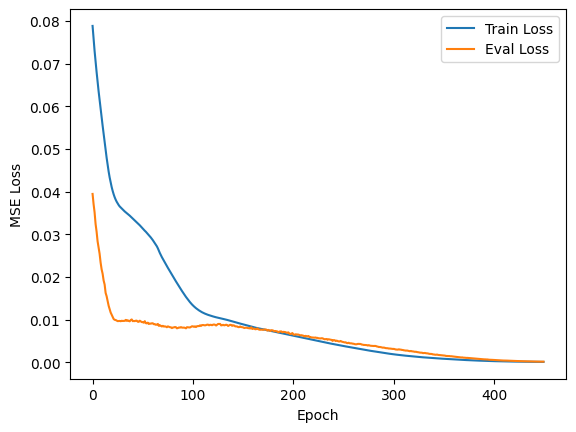

In [30]:
plt.plot(global_loss['train'], label='Train Loss')
plt.plot(global_loss['eval'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend();

In [31]:
checkpoint = {
    'model': rnn_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': global_loss
}

torch.save(checkpoint, '../output/rnn_wave.tar')

## Inference

In [33]:
rnn_model.eval()

with torch.no_grad():
    pred = torch.concat([
        rnn_model(X.cuda() if torch.cuda.is_available() else X).cpu()
        for X, _ in tqdm(DataLoader(dataset, batch_size, False))
    ]).squeeze()

100%|██████████| 157/157 [00:01<00:00, 131.66it/s]


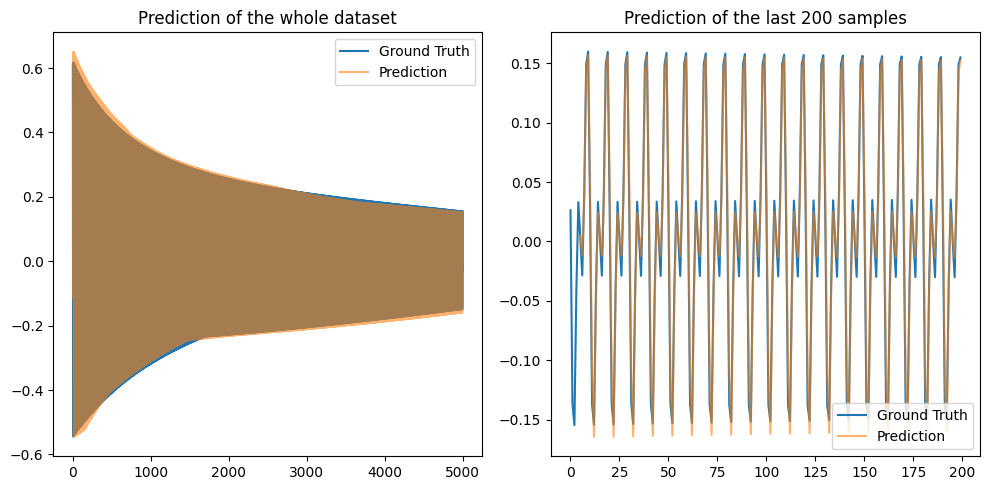

In [34]:
fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(1, 2)

axes[0].plot(data, label='Ground Truth')
axes[0].plot(list(range(5, data.shape[0])), pred, label="Prediction", alpha=.6)
axes[0].legend()
axes[0].set_title("Prediction of the whole dataset")


axes[1].plot(data[4800:], label='Ground Truth')
axes[1].plot(list(range(5, data[4800:].shape[0])), pred[4800:], label="Prediction", alpha=.6)
axes[1].legend()
axes[1].set_title("Prediction of the last 200 samples")

fig.tight_layout();

Just like the MLP, this model can fit just as well while taking more epochs to converge.

However, with this model, we can now predict on a variable amount of input sequences.

# Inference with different lag

In [ ]:
lags = [WaveDataset(data, i) for i in range(3, 9)]

with torch.no_grad():
    pred = [
        torch.concat([
            rnn_model(X.cuda() if torch.cuda.is_available() else X).cpu()
            for X, _ in tqdm(DataLoader(lag, batch_size, False), desc=f'Lag duration {lag._lag_dur}')
        ])
        for lag in lags
    ]

Lag duration: 8: 100%|██████████| 156/156 [00:00<00:00, 533.64it/s]


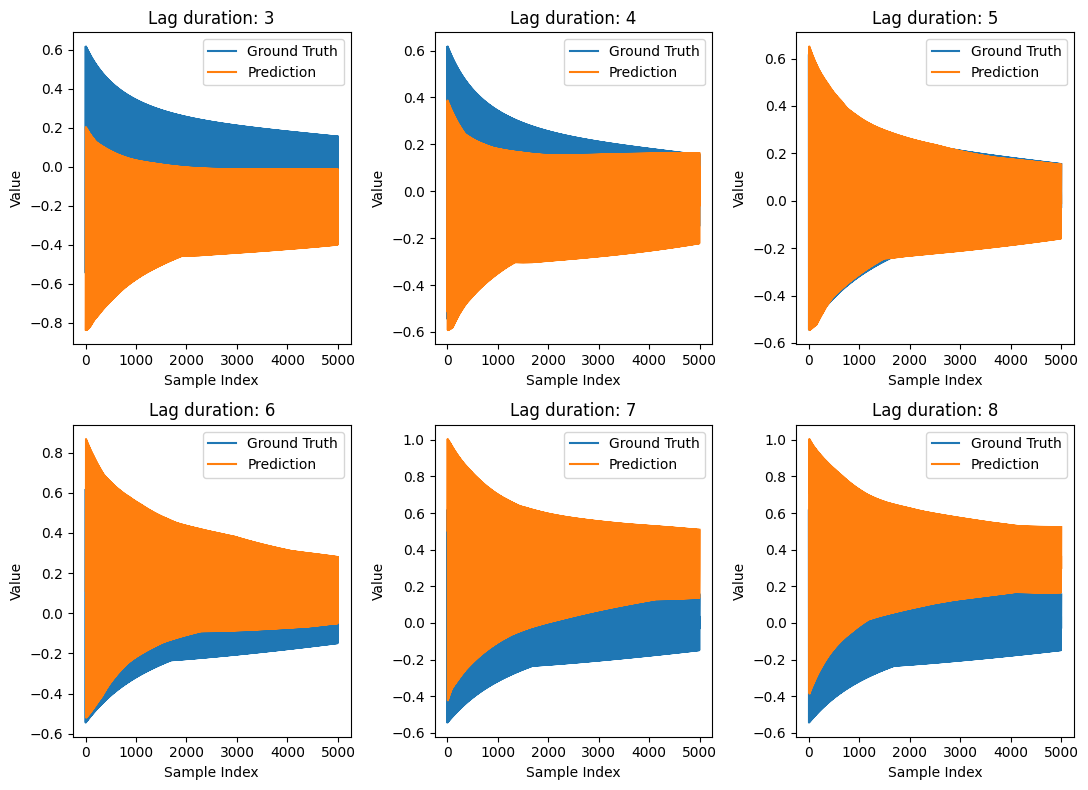

In [43]:
fig = plt.figure(figsize=(11, 8))
axes = fig.subplot_mosaic([[3, 4, 5], [6, 7, 8]])

for i in range(3, 9):
    axes[i].plot(data, label='Ground Truth')
    axes[i].plot(list(range(i, data.shape[0])), pred[i - 3], label="Prediction")

    axes[i].set_title(f"Lag duration: {i}")
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()
fig.tight_layout()

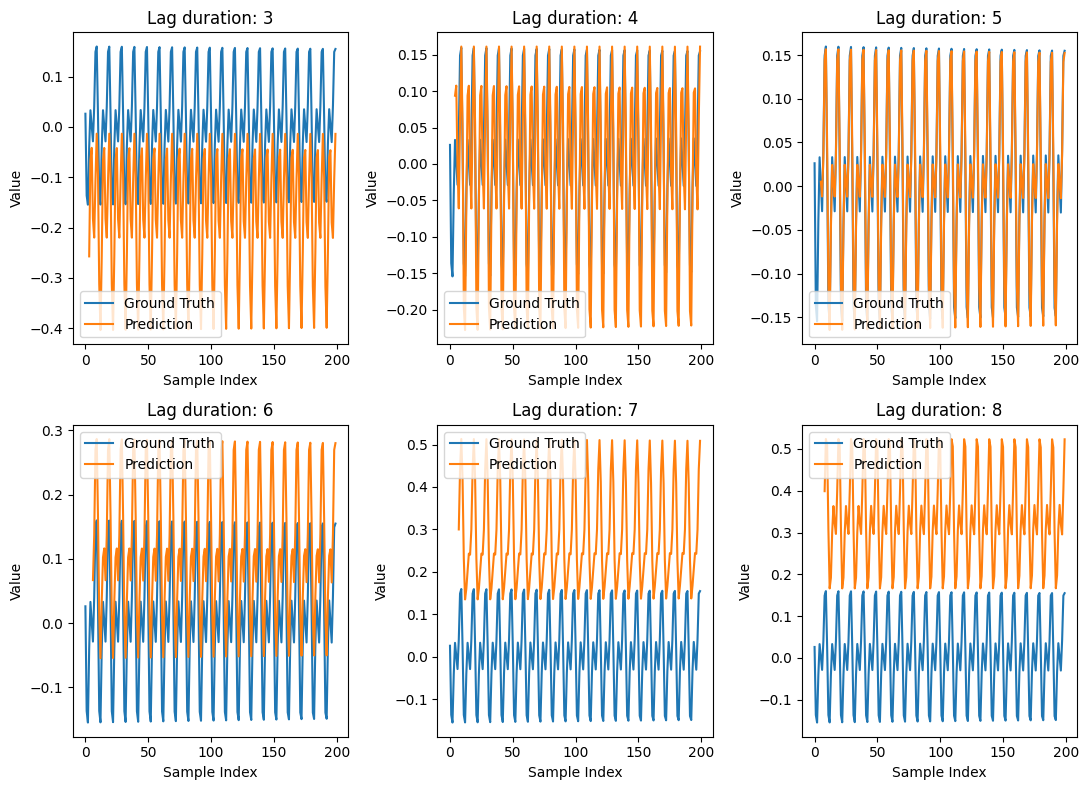

In [44]:
fig = plt.figure(figsize=(11, 8))
axes = fig.subplot_mosaic([[3, 4, 5], [6, 7, 8]])

for i in range(3, 9):
    axes[i].plot(data[4800:], label='Ground Truth')
    axes[i].plot(list(range(i, data[4800:].shape[0])), pred[i - 3][4800:], label="Prediction")

    axes[i].set_title(f"Lag duration: {i}")
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()
fig.tight_layout()

As you can see, our model does its best on a lag of 5. However, with other lag duration, the model can identifies the general trend of the data. For lower lag, the model underestimates more. Likewise, the model overestimate for higher lag.

We may notice this through the fact that the model re-uses the same weight for each lagged feature. This is essentially a composition of matrix multiplication. This implies, with the more lag, values with magnitudes above 1 will have a tendency to 'explode'.

Not only do the values 'explode', the repeated composition of multiplication will also lead to its derivative approaching infity, a phenomenon called **exploding gradient**. Or in the case for values of magnitudes less than 1, the gradients will tend to 0, a phenomenon called **vanishing gradient**.